# Statistical Analysis of Basic Baskets

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import sys
import os

# Pega o Diretório de Trabalho Atual (que deve ser 'SUPERVISED-LEARNING')
project_path = os.getcwd() 

# Adiciona este diretório ao "caminho de busca" do Python
if project_path not in sys.path:
    sys.path.append(project_path)

print(f"Adicionado ao path: {project_path}")

Adicionado ao path: /workspace/project


In [9]:
from classes.datacleaner import DataCleaner

In [10]:
df = pd.read_excel('data/ICB_2s-2025.xlsx')
df.head()

,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK
0,2022-09-12,SUP-0,Leite,Parmalat,6.28,1.0,6.280
1,2022-09-12,SUP-1,Tomate,NaN,6.99,1.0,6.990
2,2022-09-12,SUP-2,Arroz,Namorado,17.98,5.0,3.596
3,2022-09-12,SUP-2,Arroz,Broto Legal,22.69,5.0,4.538
4,2022-09-12,SUP-0,Feijão,Broto Legal,10.98,1.0,NaN


## *Data Overview*

In [11]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)

print("\nMissing Values:")
df.isnull().sum()

Dataset Shape: (34032, 7)

Missing Values:


Data_Coleta           0
Estabelecimento       0
Produto               0
Marca              6395
Preco                 0
Quantidade            0
PPK                   1
dtype: int64

In [12]:
numerical_cols = df.select_dtypes(include=[np.number]).columns

print(f"\nNumerical Columns: {len(numerical_cols)}")
print(f"Categorical Columns: {len(df.select_dtypes(include=['object']).columns)}")

print("\nData Types:")
df.dtypes



Numerical Columns: 3
Categorical Columns: 3

Data Types:


Data_Coleta        datetime64[ns]
Estabelecimento            object
Produto                    object
Marca                      object
Preco                     float64
Quantidade                float64
PPK                       float64
dtype: object

## *Exploration & Cleanup*

<Axes: xlabel='Produto'>

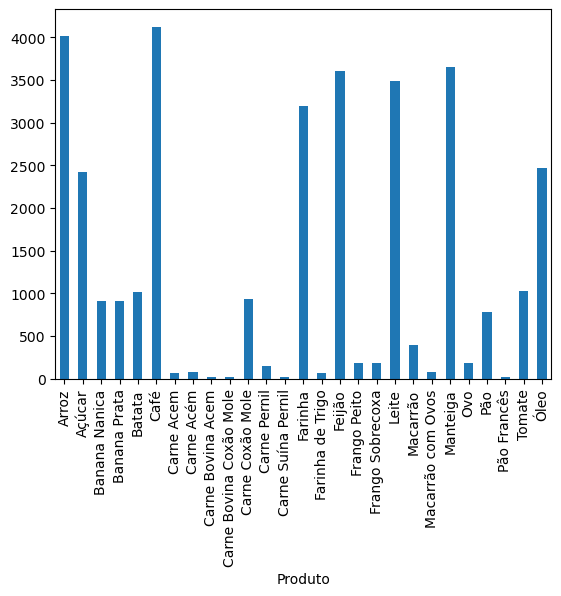

In [13]:
df.groupby('Produto').size().plot(kind='bar')

### Combination of Product Classes

In [14]:
# Function to list unique products
def list_products(df):
    products = df['Produto'].unique()
    print(f"\nProdutos encontrados:")
    for i, product in enumerate(products, 1):
        print(f"{i}. {product}")

In [15]:
# Count total distinct products
total_distinct_products = df['Produto'].unique()
print(f"Total de produtos distintos: {len(total_distinct_products)}")

# Show all distinct products
list_products(df)

Total de produtos distintos: 27

Produtos encontrados:
1. Leite
2. Tomate
3. Arroz
4. Feijão
5. Açúcar
6. Manteiga
7. Óleo
8. Carne Coxão Mole
9. Café
10. Banana Prata
11. Farinha
12. Batata
13. Banana Nanica
14. Pão
15. Frango Peito
16. Macarrão
17. Carne Pernil
18. Ovo
19. Carne Acém
20. Frango Sobrecoxa
21. Carne Acem
22. Farinha de Trigo
23. Macarrão com Ovos
24. Pão Francês
25. Carne Bovina Acem
26. Carne Bovina Coxão Mole
27. Carne Suína Pernil


#### Carne Bovina Acém
Replacing Acem variations into a single type

In [16]:
mapping = {k: "Carne Bovina Acém" for k in ['Carne Acém', 'Carne Acem', 'Carne Bovina Acem']}
df['Produto'] = df['Produto'].replace(mapping)

distinct_products = df['Produto'].unique()
print(f"Novo total de produtos distintos: {len(distinct_products)}")

Novo total de produtos distintos: 25


#### Carne Bovina Coxão Mole
Replacing Carne Coxão Mole variation into a single type

In [17]:
df['Produto'] = df['Produto'].replace({'Carne Coxão Mole': 'Carne Bovina Coxão Mole'})

#### Pão
Analysis and replacement of 'Pão Francês' to 'Pão'

In [18]:
pao = df[df['Produto'] == 'Pão']
pao_frances = df[df['Produto'] == 'Pão Francês']

In [19]:
# Comparative statistical summary: Pão vs Pão Francês
cols = ['Preco']

def summarize(s):
    s = s.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    return {
        'count': int(s.count()),
        'mean': float(s.mean()),
        'median': float(s.median()),
        'std': float(s.std()),
        'min': float(s.min()),
        'max': float(s.max()),
        'q1': float(q1),
        'q3': float(q3),
        'iqr': float(q3 - q1)
    }

results = {}
for col in cols:
    s1 = pao[col]
    s2 = pao_frances[col]
    results[col] = {
        'pao': summarize(s1),
        'pao_frances': summarize(s2),
        'mean_diff': float(s1.mean() - s2.mean()),
    }

# Print concise table-like summary
for col, res in results.items():
    print(f"--- {col} ---")
    print("Pão:      ", res['pao'])
    print("Pão Francês:", res['pao_frances'])
    print(f"Mean difference (Pão - Pão Francês): {res['mean_diff']:.4f}")
    print()

--- Preco ---
Pão:       {'count': 783, 'mean': 16.290217113665392, 'median': 15.99, 'std': 1.7672672645966503, 'min': 3.9, 'max': 26.5, 'q1': 15.79, 'q3': 16.99, 'iqr': 1.1999999999999993}
Pão Francês: {'count': 23, 'mean': 17.819130434782608, 'median': 17.99, 'std': 1.5293370906241999, 'min': 14.9, 'max': 19.99, 'q1': 16.924999999999997, 'q3': 18.945, 'iqr': 2.020000000000003}
Mean difference (Pão - Pão Francês): -1.5289



>Given the minimal diferences saw, we could infer them as being equal. As well, since 'Pão Francês' has little samples at all, it would not be meaningful to keep.

In [20]:
df['Produto'] = df['Produto'].replace({'Pão Francês': 'Pão'})

#### Farinha de Trigo
Analysis and replacement of 'Farinha' into 'Farinha de Trigo'

In [21]:
farinha = df[df['Produto'] == 'Farinha']
farinha_trigo = df[df['Produto'] == 'Farinha de Trigo']

In [22]:
results = {}
for col in cols:
    s1 = farinha[col]
    s2 = farinha_trigo[col]
    results[col] = {
        'farinha': summarize(s1),
        'farinha_trigo': summarize(s2),
        'mean_diff': float(s1.mean() - s2.mean()),
    }

# Print concise table-like summary
for col, res in results.items():
    print(f"--- {col} ---")
    print("Farinha:      ", res['farinha'])
    print("Farinha de Trigo:", res['farinha_trigo'])
    print(f"Mean difference (Farinha - Farinha de Trigo): {res['mean_diff']:.4f}")
    print()

--- Preco ---
Farinha:       {'count': 3199, 'mean': 6.033514535792435, 'median': 5.99, 'std': 1.3034269372786742, 'min': 2.49, 'max': 13.99, 'q1': 5.09, 'q3': 6.99, 'iqr': 1.9000000000000004}
Farinha de Trigo: {'count': 72, 'mean': 5.797499999999999, 'median': 5.59, 'std': 1.3116903941635176, 'min': 2.99, 'max': 9.99, 'q1': 4.99, 'q3': 6.49, 'iqr': 1.5}
Mean difference (Farinha - Farinha de Trigo): 0.2360



>Given the minimal diferences saw, we could infer them as being equal. We will keep the products as 'Farinha de Trigo' due to its more representative quality too.

In [23]:
df['Produto'] = df['Produto'].replace({'Farinha': 'Farinha de Trigo'})

#### Macarrão
We see the same pattern occurs between 'Macarrão' vs 'Macarrão com Ovos', so we will joint those into 'Macarrão'

In [24]:
df['Produto'] = df['Produto'].replace({'Macarrão com Ovos': 'Macarrão'})

#### Carne Suína Pernil
As found in Acem problem, we have a type of meat being replicated here, so we will joint the two types into the more representative "Carne Suína Pernil" label

In [25]:
df['Produto'] = df['Produto'].replace({'Carnel Pernil': 'Carne Suína Pernil'})

#### Final Results (New Product List)

In [26]:
print(f"Number of merged products classes: {len(total_distinct_products) - len(df['Produto'].unique())}")
print("\nUpdated Product List:")
list_products(df)

Number of merged products classes: 6

Updated Product List:

Produtos encontrados:
1. Leite
2. Tomate
3. Arroz
4. Feijão
5. Açúcar
6. Manteiga
7. Óleo
8. Carne Bovina Coxão Mole
9. Café
10. Banana Prata
11. Farinha de Trigo
12. Batata
13. Banana Nanica
14. Pão
15. Frango Peito
16. Macarrão
17. Carne Pernil
18. Ovo
19. Carne Bovina Acém
20. Frango Sobrecoxa
21. Carne Suína Pernil


### Products Categorization
For even more easily analysis, we will leave a formal dict with products distinguished by general classes

In [27]:
# Addressing Products to classes
product_classes = {
    'Vegetais': ['Tomate', 'Banana Prata', 'Banana Nanica', 'Batata'],
    'Carnes Vermelhas': ['Carne Bovina Acém', 'Carne Bovina Coxão Mole', 
               'Carne Suína Pernil'],
    'Aves': ['Frango Peito', 'Frango Sobrecoxa'],
    'Laticínios': ['Manteiga', 'Leite'],
    'Padaria & Cozinha': ['Pão', 'Ovo', 'Farinha de Trigo', 'Café', 'Açúcar', 'Óleo'],
    'Grãos & Massas': ['Arroz', 'Feijão', 'Macarrão'],
}
# invert product_classes into product -> class mapping
prod_to_class = {prod: cls for cls, prods in product_classes.items() for prod in prods}

# dataframe with each distinct product and its class
class_df = pd.DataFrame({'Produto': df['Produto'].unique()})
class_df['Classe'] = class_df['Produto'].map(prod_to_class).fillna('Unassigned')
class_df = class_df.sort_values('Classe').reset_index(drop=True)

class_df



,Produto,Classe
0,Frango Peito,Aves
1,Frango Sobrecoxa,Aves
2,Carne Suína Pernil,Carnes Vermelhas
3,Carne Bovina Acém,Carnes Vermelhas
4,Carne Bovina Coxão Mole,Carnes Vermelhas
5,Arroz,Grãos & Massas
6,Feijão,Grãos & Massas
7,Macarrão,Grãos & Massas
8,Leite,Laticínios
9,Manteiga,Laticínios


In [28]:
# Adicionando a coluna 'Classe' ao DataFrame principal usando o mapeamento
df['Classe'] = df['Produto'].map(prod_to_class)

### Brand Analysis

#### Products without brand
To ensure consistency, we will assign the **known product classes with no brand** to the value 'Sem Marca'

In [29]:
# Product classes without 'Marca': all meat types, all fruit types, eggs, bread
without_brand = ['Tomate', 'Banana Prata', 'Banana Nanica', 'Batata',
                 'Pão', 'Frango Peito', 'Ovo', 'Carne Bovina Acém', 
                 'Frango Sobrecoxa', 'Carne Bovina Coxão Mole', 'Carne Suína Pernil']
print(f'Quantity of product classes without brand attached to: {len(without_brand)}')

# Assign 'Sem Marca' to products without brand
df = df.copy()
df.loc[df['Produto'].isin(without_brand), 'Marca'] = 'Sem Marca'
df[df['Produto'].isin(without_brand)].head()

Quantity of product classes without brand attached to: 11


,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK,Classe
1,2022-09-12,SUP-1,Tomate,Sem Marca,6.99,1.0,6.99,Vegetais
11,2022-09-12,SUP-0,Carne Bovina Coxão Mole,Sem Marca,42.90,1.0,42.90,Carnes Vermelhas
13,2022-09-12,SUP-4,Carne Bovina Coxão Mole,Sem Marca,42.93,1.0,42.93,Carnes Vermelhas
20,2022-09-12,SUP-0,Tomate,Sem Marca,3.75,1.0,3.75,Vegetais
21,2022-09-12,SUP-1,Banana Prata,Sem Marca,9.90,1.0,9.90,Vegetais


#### Products without brand which should have one

In [30]:
# Count null values for each 'Produto' class
null_counts_by_product = df.groupby('Produto')['Marca'].apply(lambda x: x.isnull().sum())
null_summary_table = pd.DataFrame({
    'Produto': null_counts_by_product.index,
    'Null_Marca_Count': null_counts_by_product.values,
    'Total_Records': df.groupby('Produto').size().values,
    'Null_Percentage': (null_counts_by_product.values / df.groupby('Produto').size().values * 100).round(2)
})

null_summary_table = null_summary_table.sort_values('Null_Marca_Count', ascending=False)
null_summary_table


,Produto,Null_Marca_Count,Total_Records,Null_Percentage
8,Carne Pernil,154,154,100.00
14,Leite,8,3490,0.23
11,Feijão,5,3602,0.14
0,Arroz,4,4015,0.10
5,Café,4,4122,0.10
10,Farinha de Trigo,3,3271,0.09
16,Manteiga,2,3645,0.05
1,Açúcar,1,2420,0.04
20,Óleo,1,2466,0.04
6,Carne Bovina Acém,0,174,0.00


> Due to the notiable small ammount of null values, we can securely discart those...

In [31]:
# Remotion of null values in 'Marca' column
df = df.dropna(subset=['Marca'])

#### Brands incorrectly assigned
The dataset has several mistypes on brand assignation of products, so we need to fix those

In [32]:
# Convert all brands to string type to handle mixed data types
df['Marca'] = df['Marca'].astype(str)

# Get unique brands and sort alphabetically
unique_brands = pd.DataFrame(df['Marca'].unique())
unique_brands = unique_brands.sort_values(by=0).reset_index(drop=True)

print(f'Total unique brands: {len(unique_brands)}')

unique_brands_array = unique_brands.values.flatten()
unique_brands_array


Total unique brands: 168


array(['3 Corações', '3 corações', 'Adria', 'Albaruska', 'Albaruska ',
       'Alto Alegre', 'Alto Alegre ', 'Anaconda', 'Aro', 'Aurora',
       'Aviação', 'Batavo', 'Bela Nata', 'Belarina', 'Biguá', 'Biju',
       'Bonolat', 'Brasileirissima', 'Broto Legal', 'Buque', 'Caboclo',
       'Caldo Bom', 'Caldo Nobre', 'Camil', 'Camil ', 'Canecão',
       'Caravelas', 'Carrefour', 'Catupiry', 'Celina', 'Claybom', 'Coamo',
       'Cocamar', 'Colombo', 'Concórdia', 'Corina', 'Cruzilia', 'DIA',
       'Da Barra', 'Da Casa', 'Da Vaca', 'DaVaca', 'Danone', 'Davaca',
       'Delícia', 'Dia', 'Dona Benta', 'Doriana', 'Dualis', 'Elegê',
       'Emporio São João', 'Empório São João', 'Famiglia Venturelli',
       'Fantástico', 'Fort', 'Frimesa', 'Galo', 'Gaspar', 'Globo',
       'Grão De Campo', 'Grão Do Campo', 'Grão de campo',
       'Grão de campo ', 'Grão do Campo', 'Guarani', 'Guarani ', 'Inari',
       'Italac', 'Itambé', 'Joli', 'Jussara', 'Kicaldo', 'Knor', 'Knorr',
       'Leco', 'Leve', 'Li

In [33]:
df['Marca'] = df['Marca'].replace({'3 corações': '3 Corações'})
df['Marca'] = df['Marca'].replace({'Albaruska ': 'Albaruska'})
df['Marca'] = df['Marca'].replace({'Alto Alegre ': 'Alto Alegre'})
df['Marca'] = df['Marca'].replace({'Camil ': 'Camil'})
df['Marca'] = df['Marca'].replace({'DaVaca': 'Da Vaca'})
df['Marca'] = df['Marca'].replace({'Davaca': 'Da Vaca'})
df['Marca'] = df['Marca'].replace({'Emporio São João': 'Empório São João'})
df['Marca'] = df['Marca'].replace({'Grão De Campo': 'Grão Do Campo'})
df['Marca'] = df['Marca'].replace({'Grão de Campo': 'Grão Do Campo'})
df['Marca'] = df['Marca'].replace({'Grão de Campo ': 'Grão Do Campo'})
df['Marca'] = df['Marca'].replace({'Grão do Campo': 'Grão Do Campo'})
df['Marca'] = df['Marca'].replace({'Guarani ': 'Guarani'})
df['Marca'] = df['Marca'].replace({'Knor': 'Knorr'})
df['Marca'] = df['Marca'].replace({'Lider': 'Líder'})
df['Marca'] = df['Marca'].replace({'Outra': 'Outro'})
df['Marca'] = df['Marca'].replace({'Outro2': 'Outro'})
df['Marca'] = df['Marca'].replace({'Pateko': 'Patéko'})
df['Marca'] = df['Marca'].replace({'Paulista ': 'Paulista'})
df['Marca'] = df['Marca'].replace({'Piracanjuba ': 'Piracanjuba'})
df['Marca'] = df['Marca'].replace({'Prato Fino ': 'Prato Fino'})
df['Marca'] = df['Marca'].replace({'Qualita': 'Qualitá'})
df['Marca'] = df['Marca'].replace({'Renata ': 'Renata'})
df['Marca'] = df['Marca'].replace({'Saboroso ': 'Saboroso'})
df['Marca'] = df['Marca'].replace({'Serrazul\n': 'Serrazul'})
df['Marca'] = df['Marca'].replace({'São': 'São Joaquim'})
df['Marca'] = df['Marca'].replace({'São Joaquim ': 'São Joaquim'})
df['Marca'] = df['Marca'].replace({'Urbano ': 'Urbano'})
df['Marca'] = df['Marca'].replace({'Vasconcelos ': 'Vasconcelos'})

print(f'New total of brands after cleaning: {len(df["Marca"].unique())}')

New total of brands after cleaning: 142


##### Sub-analysis: 'Outros' value assignation problemn
There is a considerable amount of records without the possibility to be corrected assigned

In [34]:
# Count 'Outro' values for each 'Produto' class (strip and lowercase to catch variants)
outro_counts_by_product = df.groupby('Produto')['Marca'].apply(lambda x: x.str.strip().str.lower().eq('outro').sum())
total_by_product = df.groupby('Produto').size()

outro_summary_table = pd.DataFrame({
    'Produto': outro_counts_by_product.index,
    'Outro_Marca_Count': outro_counts_by_product.values,
    'Total_Records': total_by_product.values,
    'Outro_Percentage': (outro_counts_by_product.values / total_by_product.values * 100).round(2)
})

print(f'Total of Outro brand entries: {outro_summary_table["Outro_Marca_Count"].sum()}. ({(outro_summary_table["Outro_Marca_Count"].sum() / len(df) * 100).round(2)}% of all records)')

outro_summary_table = outro_summary_table.sort_values('Outro_Marca_Count', ascending=False)
outro_summary_table


Total of Outro brand entries: 643. (1.9% of all records)


,Produto,Outro_Marca_Count,Total_Records,Outro_Percentage
15,Manteiga,168,3643,4.61
0,Arroz,93,4011,2.32
9,Farinha de Trigo,85,3268,2.60
10,Feijão,83,3597,2.31
13,Leite,71,3482,2.04
1,Açúcar,47,2419,1.94
14,Macarrão,39,472,8.26
19,Óleo,35,2465,1.42
5,Café,22,4118,0.53
4,Batata,0,1018,0.00


> <span style="color:red">**WAITING REVIEW**</span> <br>
required to see what we will do with those products...

#### Brands review by Product
Analysis to look statistical information of each product type, based on it's brand

In [35]:
# Function for brand statistical review by product
def analyze_brand_by_product(df, product_name, price_col='Preco', iqr_threshold=1.5):
    """
    Analyze price statistics for each brand within a product.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset
    product_name : str
        Product to analyze
    price_col : str
        Price column name (default: 'Preco')
    iqr_threshold : float
        IQR multiplier for outlier detection (default: 1.5)
    
    Returns:
    --------
    pd.DataFrame : Statistics for each brand
    """
    
    product_data = df[df['Produto'] == product_name]
    
    if len(product_data) == 0:
        return pd.DataFrame()
    
    results = []
    
    for brand in product_data['Marca'].unique():
        brand_data = product_data[product_data['Marca'] == brand][price_col].dropna()
        
        q1 = brand_data.quantile(0.25)
        q3 = brand_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - iqr_threshold * iqr
        upper_bound = q3 + iqr_threshold * iqr
        
        outliers = brand_data[(brand_data < lower_bound) | (brand_data > upper_bound)]
        
        results.append({
            'Marca': brand,
            'count': len(brand_data),
            'mean': brand_data.mean(),
            'q1': q1,
            'median': brand_data.median(),
            'q3': q3,
            'outlier_count': len(outliers),
            'outlier_percentage': (len(outliers) / len(brand_data) * 100) if len(brand_data) > 0 else 0
        })
    
    return pd.DataFrame(results).sort_values('Marca').reset_index(drop=True)

In [36]:
# Usage example:
print("Manteiga brands analysis:")
analyze_brand_by_product(df, 'Manteiga')

Manteiga brands analysis:


,Marca,count,mean,q1,median,q3,outlier_count,outlier_percentage
0,Aviação,825,15.773491,13.9900,14.990,16.9900,19,2.303030
1,Batavo,450,12.920222,11.8900,12.590,13.2900,27,6.000000
2,Bela Nata,1,10.300000,10.3000,10.300,10.3000,0,0.000000
3,Brasileirissima,1,13.490000,13.4900,13.490,13.4900,0,0.000000
4,Carrefour,4,15.040000,10.9400,11.490,15.5900,1,25.000000
5,Catupiry,2,8.190000,7.0400,8.190,9.3400,0,0.000000
6,Claybom,6,5.946667,3.8325,6.540,7.7400,0,0.000000
7,Cruzilia,1,10.490000,10.4900,10.490,10.4900,0,0.000000
8,Da Vaca,145,13.238276,11.9900,12.990,13.9900,4,2.758621
9,Danone,467,13.249872,11.7000,12.950,14.7400,4,0.856531


In [37]:
cleaner = DataCleaner(df)
df_limpo = cleaner.clean_all(
    remove_duplicates=True,
    missing_threshold=0.5,
    outlier_method='iqr',
    encode=True,
    normalize=False
)

INICIANDO LIMPEZA COMPLETA DO DATASET
Analisando estrutura dos dados

Total de linhas: 33850
Total de colunas: 8
   - Numéricas: 3
   - Categóricas: 4
   - Data/Hora: 1
Linhas duplicadas: 1

Valores ausentes encontrados em 1 colunas:
   - PPK: 1 (0.00%)
Removidas 1 linhas duplicadas

Tratando valores ausentes...
   Preenchendo 1 colunas numéricas...

Tratando outliers (método: iqr, ação: cap)...
   Outliers tratados em 3 colunas

Codificando variáveis categóricas...
   Codificadas 4 colunas
LIMPEZA CONCLUÍDA!

Resumo das transformações:
   Linhas originais: 33850
   Linhas finais: 33849
   Colunas originais: 8
   Colunas finais: 12
   Duplicatas removidas: 1
   Colunas com outliers tratados: 3
   Colunas codificadas: 4


In [38]:
df

,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK,Classe
0,2022-09-12,SUP-0,Leite,Parmalat,6.28,1.0,6.280000,Laticínios
1,2022-09-12,SUP-1,Tomate,Sem Marca,6.99,1.0,6.990000,Vegetais
2,2022-09-12,SUP-2,Arroz,Namorado,17.98,5.0,3.596000,Grãos & Massas
3,2022-09-12,SUP-2,Arroz,Broto Legal,22.69,5.0,4.538000,Grãos & Massas
4,2022-09-12,SUP-0,Feijão,Broto Legal,10.98,1.0,NaN,Grãos & Massas
...,...,...,...,...,...,...,...,...
34027,2025-09-22,SUP-2,Manteiga,Outro,17.99,0.2,89.950000,Laticínios
34028,2025-09-22,SUP-0,Café,Caboclo,29.95,0.5,59.900000,Padaria & Cozinha
34029,2025-09-22,SUP-2,Leite,Ninho,7.99,1.0,7.990000,Laticínios
34030,2025-09-22,SUP-0,Arroz,Empório São João,29.99,5.0,5.998000,Grãos & Massas


In [39]:
df_limpo.head()

,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK,Classe_Carnes Vermelhas,Classe_Grãos & Massas,Classe_Laticínios,Classe_Padaria & Cozinha,Classe_Vegetais
0,2022-09-12,0,13,88,6.28,1.00,6.280,False,False,True,False,False
1,2022-09-12,1,18,116,6.99,1.00,6.990,False,False,False,False,True
2,2022-09-12,12,0,74,17.98,1.15,3.596,False,True,False,False,False
3,2022-09-12,12,0,15,22.69,1.15,4.538,False,True,False,False,False
4,2022-09-12,0,10,15,10.98,1.00,7.596,False,True,False,False,False


In [40]:
import json

mapeamentos = cleaner.label_mappings

for coluna, mapa in mapeamentos.items():
    with open(f'./data/mapa_{coluna}.json', 'w', encoding='utf-8') as f:
        json.dump(mapa, f, ensure_ascii=False, indent=4)

print("Mapeamentos salvos com sucesso em ./data/")

Mapeamentos salvos com sucesso em ./data/


In [41]:
# Salvando os dados limpos dentro da pasta dados
df_limpo.to_excel('data/dados_limpos_ICB.xlsx', index=False)

### Análise Temporal de Preços de Produtos Vegetais

In [42]:
vegetais = df_limpo[df_limpo['Classe_Vegetais'] == True]

In [43]:
# Carregar o mapeamento de Produto do arquivo JSON
with open('./data/mapa_Produto.json', 'r', encoding='utf-8') as f:
    produto_mapping = json.load(f)

# Inverter o mapeamento (de código para nome)
produto_mapping_invertido = {v: k for k, v in produto_mapping.items()}

# Primeiro decodificar os nomes dos produtos no DataFrame principal de vegetais
vegetais['Produto'] = vegetais['Produto'].map(lambda x: produto_mapping_invertido.get(x, x))

# Agora criar os datasets individuais usando os nomes decodificados
tomate_df = vegetais[vegetais['Produto'] == 'Tomate']
banana_prata_df = vegetais[vegetais['Produto'] == 'Banana Prata']
banana_nanica_df = vegetais[vegetais['Produto'] == 'Banana Nanica']
batata_df = vegetais[vegetais['Produto'] == 'Batata']

# Verificar os datasets
print("Tamanho dos datasets:")
print(f"Tomate: {len(tomate_df)} registros")
print(f"Banana Prata: {len(banana_prata_df)} registros")
print(f"Banana Nanica: {len(banana_nanica_df)} registros")
print(f"Batata: {len(batata_df)} registros")

Tamanho dos datasets:
Tomate: 1027 registros
Banana Prata: 911 registros
Banana Nanica: 910 registros
Batata: 1018 registros


In [44]:
tomate_df.describe()

,Data_Coleta,Estabelecimento,Marca,Preco,Quantidade,PPK
count,1027,1027.000000,1027.0,1027.000000,1027.000000,1027.000000
mean,2024-03-14 13:41:39.318403072,17.375852,116.0,8.881587,1.000292,8.862180
min,2022-09-12 00:00:00,0.000000,116.0,2.950000,1.000000,0.449500
25%,2023-06-13 00:00:00,8.000000,116.0,6.990000,1.000000,6.990000
50%,2024-03-14 00:00:00,16.000000,116.0,8.990000,1.000000,8.990000
75%,2024-12-17 00:00:00,23.000000,116.0,10.890000,1.000000,10.890000
max,2025-09-22 00:00:00,40.000000,116.0,17.990000,1.150000,17.990000
std,NaN,11.886686,0.0,2.736823,0.006616,2.759809


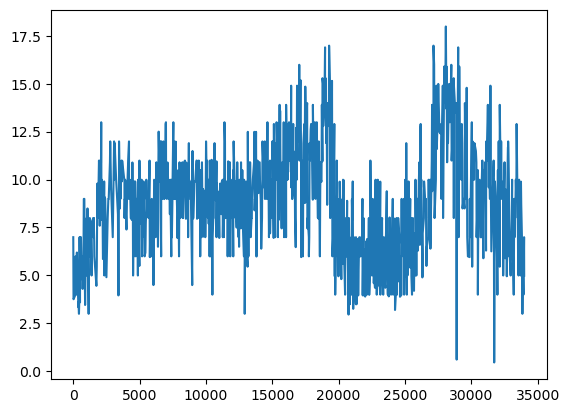

In [45]:
plt.plot(tomate_df['PPK'])

In [46]:
# Calcular a média diária dos preços do tomate
tomate_df_daily = tomate_df.groupby('Data_Coleta')['PPK'].mean().reset_index()
tomate_df_daily = tomate_df_daily.set_index('Data_Coleta')

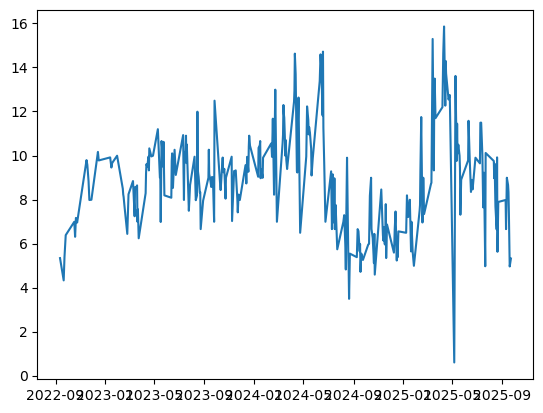

In [47]:
plt.plot(tomate_df_daily['PPK'])

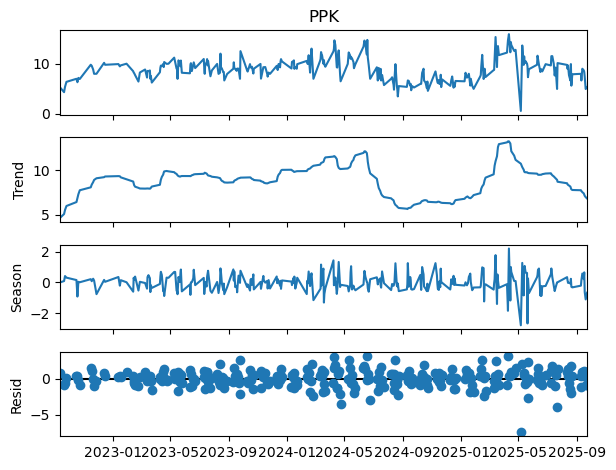

In [48]:
# Decomposição STL
from statsmodels.tsa.seasonal import STL

stl = STL(tomate_df_daily['PPK'], period=7)
res = stl.fit()
res.plot()
plt.show()

In [49]:
# Adicionar coluna com dia da semana
tomate_df_daily['dia_semana'] = tomate_df_daily.index.dayofweek
tomate_df_daily['dia_semana_nome'] = tomate_df_daily.index.day_name()

# Analisar distribuição de preços por dia da semana
distribuicao_dias = tomate_df_daily.groupby('dia_semana_nome')['PPK'].agg(['count', 'mean', 'std']).round(2)
print("Distribuição por dia da semana:")
print(distribuicao_dias)

Distribuição por dia da semana:
                 count   mean   std
dia_semana_nome                    
Friday              75   9.23  2.26
Monday              77   8.41  1.98
Saturday             1   5.99   NaN
Thursday             5  10.48  2.04
Tuesday             71   8.94  2.36
Wednesday           68   8.78  2.50


Iremos, portanto, remover os fins de semana para focar na análise dos dias úteis e dividiremos o dataset em semanas.


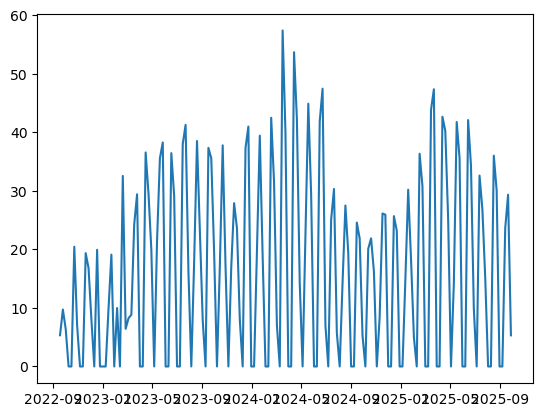

In [50]:
tomate_df_daily = tomate_df_daily[tomate_df_daily['dia_semana'].isin([0, 1, 2, 3, 4])]
tomate_semanal = tomate_df_daily.resample('W').sum()
tomate_semanal = tomate_semanal.drop(columns=['dia_semana', 'dia_semana_nome'])
plt.plot(tomate_semanal['PPK'])

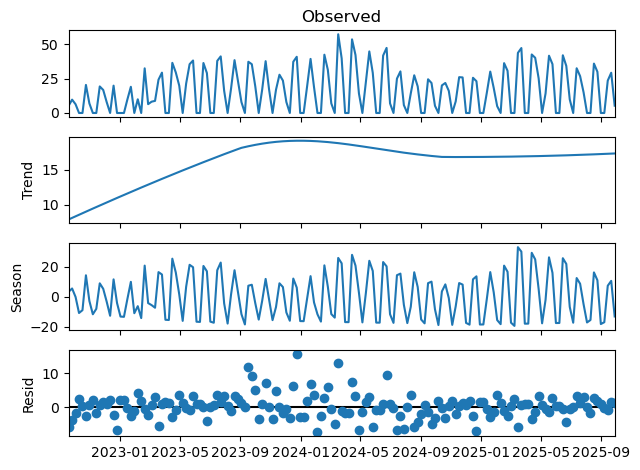

In [51]:
stl = STL(tomate_semanal)
res = stl.fit()
res.plot()
plt.show()

O dataset semanal se comporta melhor para a decomposição STL, visto que o ruído diário e as inconsistências pela falta de dados são reduzidas.

[]

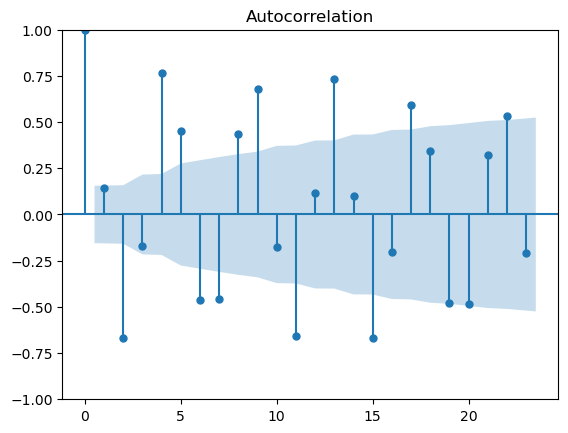

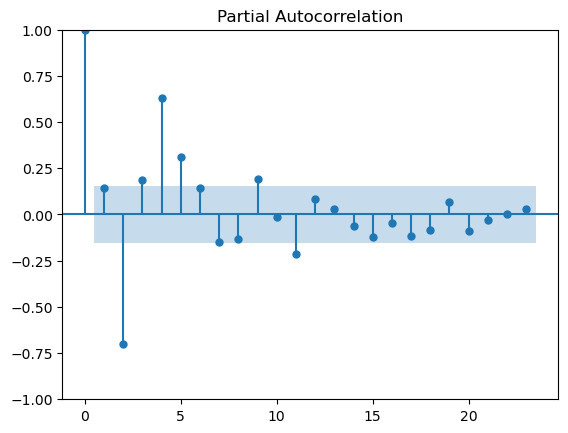

In [52]:
# Plotando ACF e PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(tomate_semanal['PPK'])
plot_pacf(tomate_semanal['PPK'])
plt.plot()

Diferenciaremos para remover tendências e analisar a estacionariedade da série temporal.

[]

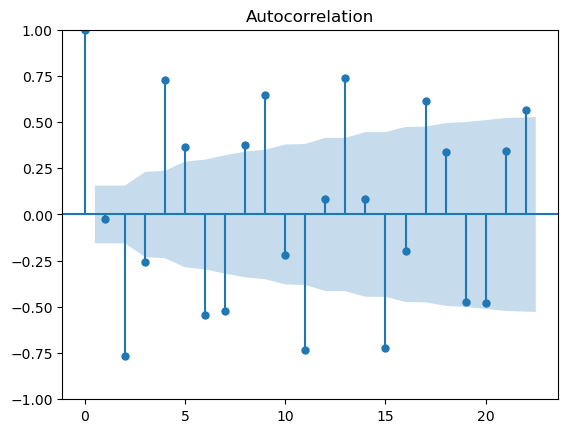

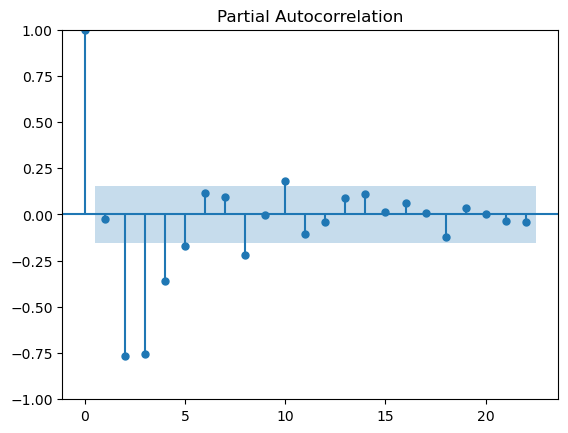

In [53]:
plot_acf(tomate_semanal['PPK'].diff(1).dropna())
plot_pacf(tomate_semanal['PPK'].diff(1).dropna())
plt.plot()

Ainda há uma componente sazonal semanal, o que indica que os preços tendem a variar de acordo com o dia da semana, possivelmente devido a fatores como demanda e oferta específicas de cada dia.
Portanto diferenciaremos mais uma vez para tentar eliminar essa sazonalidade.

In [54]:
s = 52 

# Aplica as duas diferenciações
tomate_semanal_sarima = tomate_semanal.diff(s).diff(1).dropna()

Usaremos s=52 para capturar a sazonalidade anual, considerando que há variações sazonais ao longo do ano que podem afetar os preços dos produtos vegetais.

[]

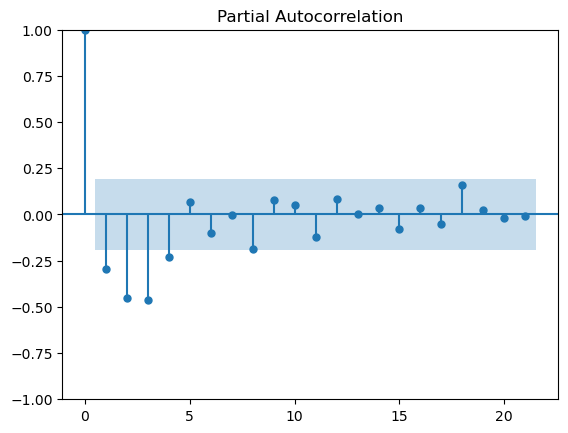

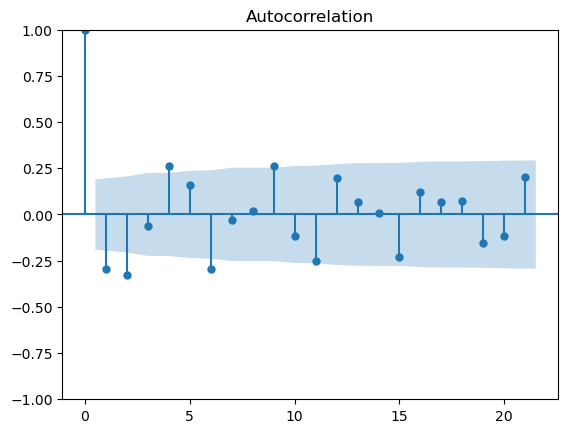

In [55]:
plot_pacf(tomate_semanal_sarima)
plot_acf(tomate_semanal_sarima)
plt.plot()

Agora estamos prontos para modelar a série temporal usando ARIMA ou SARIMA, dependendo dos resultados da análise de estacionariedade e sazonalidade.

Aplicaremos o modelo SARIMA, que é adequado para séries temporais com componentes sazonais em treino/teste.

In [56]:
percentage = 0.8
X_train, X_test = tomate_semanal_sarima[:int(len(tomate_semanal_sarima) * percentage)], tomate_semanal_sarima[int(len(tomate_semanal_sarima) * percentage):]
y_train, y_test = X_train, X_test

In [57]:
from statsmodels.tsa.api import SARIMAX

modelo = SARIMAX(y_train, 
                 order=(3, 1, 1), 
                 seasonal_order=(1, 1, 0, 4))

print("Treinando o modelo...")
modelo_ajustado = modelo.fit()

print(modelo_ajustado.summary())

Treinando o modelo...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92206D+00    |proj g|=  3.03004D-01

At iterate    5    f=  3.76714D+00    |proj g|=  3.29425D-02

At iterate   10    f=  3.69733D+00    |proj g|=  2.93382D-03

At iterate   15    f=  3.69730D+00    |proj g|=  2.91176D-03

At iterate   20    f=  3.69693D+00    |proj g|=  4.99114D-03

At iterate   25    f=  3.69677D+00    |proj g|=  1.58171D-03

At iterate   30    f=  3.69675D+00    |proj g|=  3.93998D-04

At iterate   35    f=  3.69675D+00    |proj g|=  2.30969D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     45      1     0     0   6.947D-05   3.697D+00
  F =   3.6967493939660363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                                PPK   No. Observations:                   84
Model:             SARIMAX(3, 1, 1)x(1, 1, [], 4)   Log Likelihood                -310.527
Date:                            Mon, 03 Nov 2025   AIC                            633.054
Time:                                    23:12:54   BIC    

Embora tenhamos poucos dados para analisar, o modelo SARIMA pode capturar tanto a tendência quanto a sazonalidade mensal dos preços dos produtos vegetais e teve um desempenho bom no treino e teste, com um RMSE baixo, indicando que as previsões estão próximas dos valores reais.

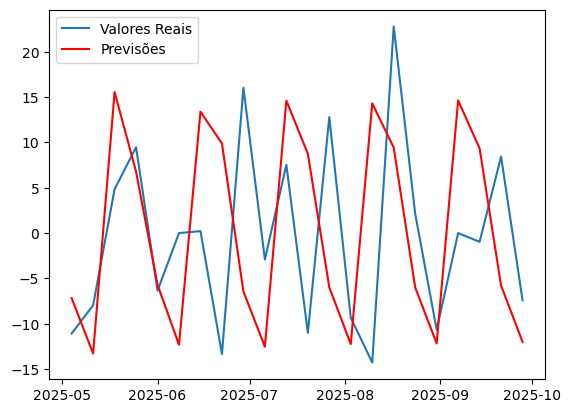

In [58]:
plt.plot(y_test.index, y_test, label='Valores Reais')
plt.plot(y_test.index, modelo_ajustado.predict(start=y_test.index[0], end=y_test.index[-1]), label='Previsões', color='red')
plt.legend()
plt.show()

A predição teve resultados ruins, e devido a mais análises já feitas que mostram a necessidade de um modelo diferente, usaremos outra abordagem.

Dessa vez faremos uma regressão usando Árvores de Decisão para prever os preços dos produtos vegetais com base em variáveis como data, dia da semana, mês e ano.

Training RMSE: 0.2144297406628749
Testing RMSE: 3.23537832343381
Training R²: 0.9895523158692668
Testing R²: -0.4037219242011365


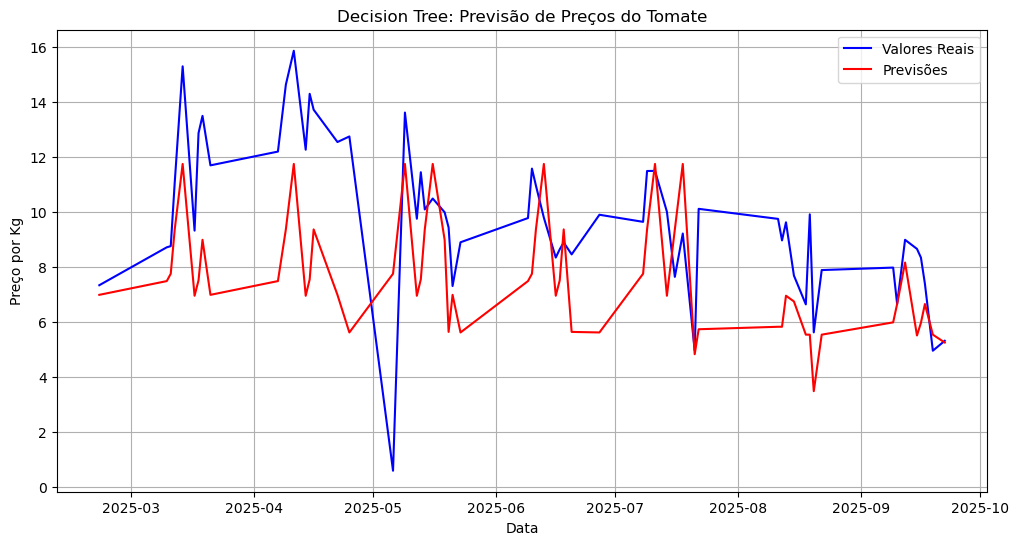

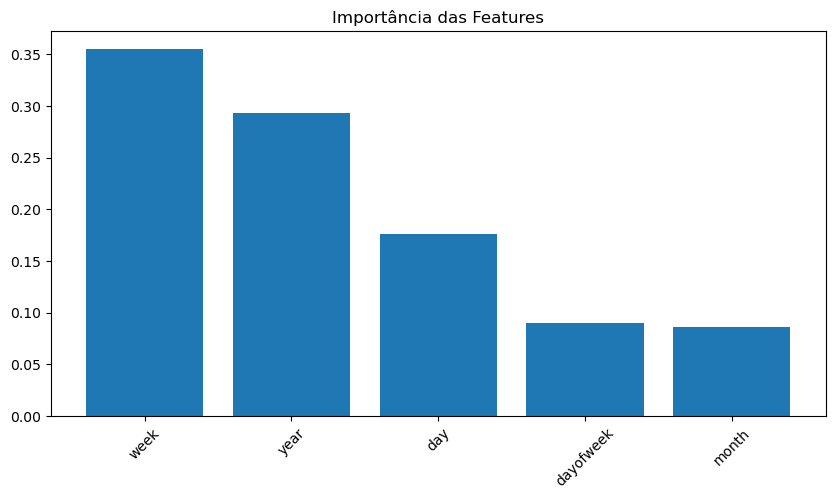

In [78]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Create features for the time series
def create_features(df):
    """Create time series features based on time index."""
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    return df

# Prepare the data
tomate_features = create_features(tomate_df_daily)

# Define features and target
features = ['year', 'month', 'week', 'day', 'dayofweek']
target = 'PPK'

# Split the data into training and testing sets (using the same 80% split as before)
train_size = int(len(tomate_features) * 0.8)
train_data = tomate_features[:train_size]
test_data = tomate_features[train_size:]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Create and train the Decision Tree model
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
train_predictions = dt_model.predict(X_train)
test_predictions = dt_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
r2_train = r2_score(y_train, train_predictions)
r2_test = r2_score(y_test, test_predictions)

print('Training RMSE:', train_rmse)
print('Testing RMSE:', test_rmse)
print('Training R²:', r2_train)
print('Testing R²:', r2_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Valores Reais', color='blue')
plt.plot(test_data.index, test_predictions, label='Previsões', color='red')
plt.title('Decision Tree: Previsão de Preços do Tomate')
plt.xlabel('Data')
plt.ylabel('Preço por Kg')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': dt_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Importância das Features')
plt.xticks(rotation=45)
plt.show()


Análise para Tomate:
Training RMSE: 0.21
Testing RMSE: 3.26
Training R²: 0.99
Testing R²: -0.42


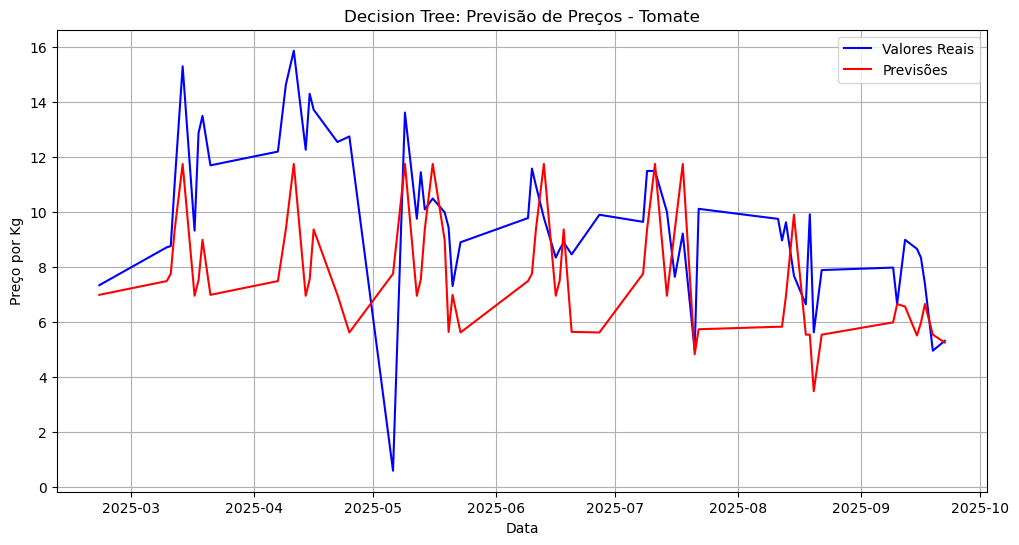

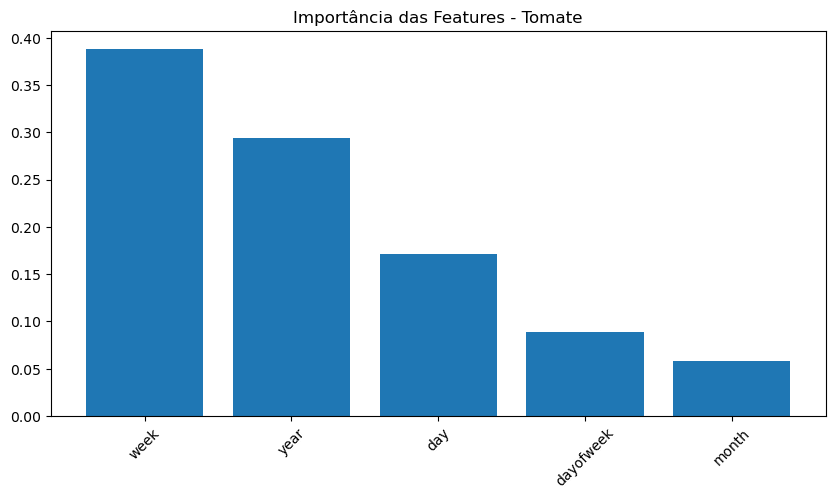


Análise para Banana Prata:
Training RMSE: 0.46
Testing RMSE: 2.48
Training R²: 0.93
Testing R²: -2.13


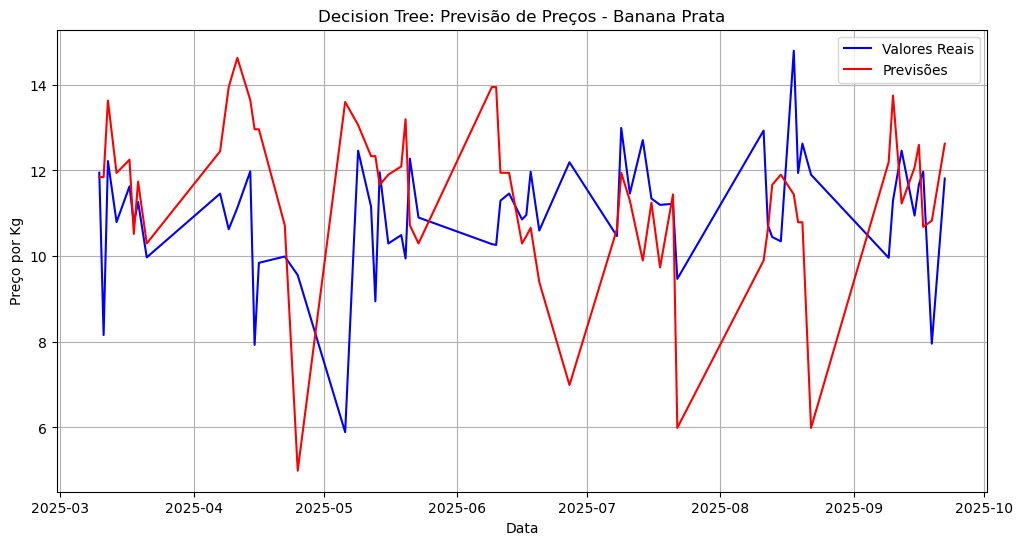

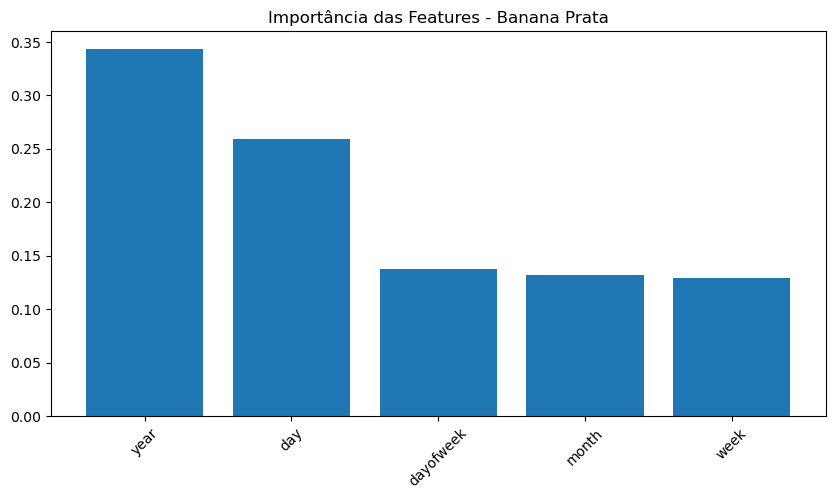


Análise para Banana Nanica:
Training RMSE: 0.26
Testing RMSE: 1.58
Training R²: 0.95
Testing R²: -1.90


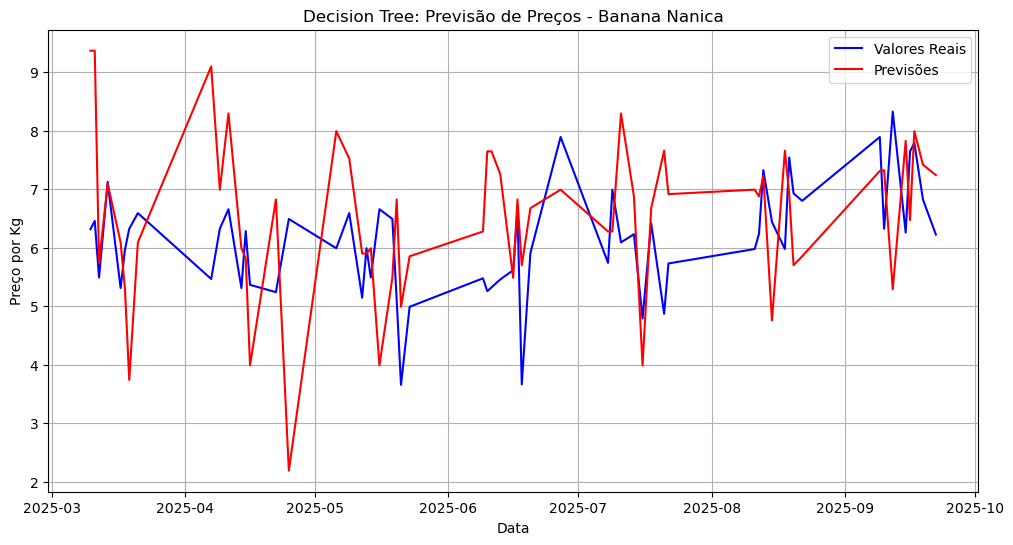

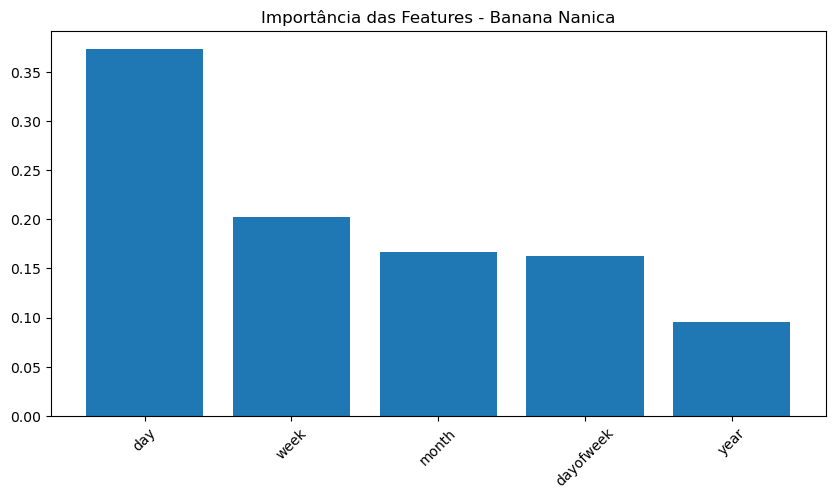


Análise para Batata:
Training RMSE: 0.37
Testing RMSE: 1.58
Training R²: 0.97
Testing R²: -0.01


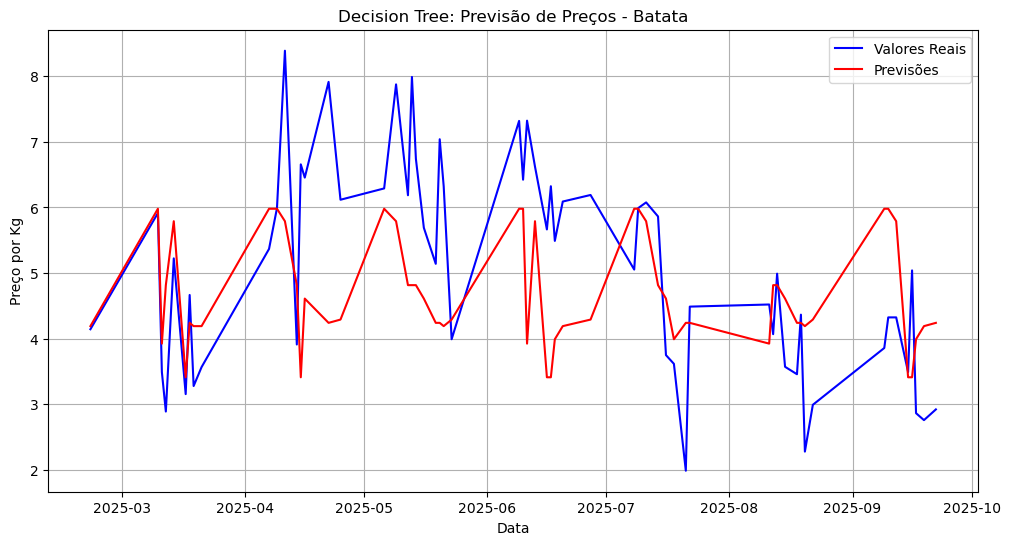

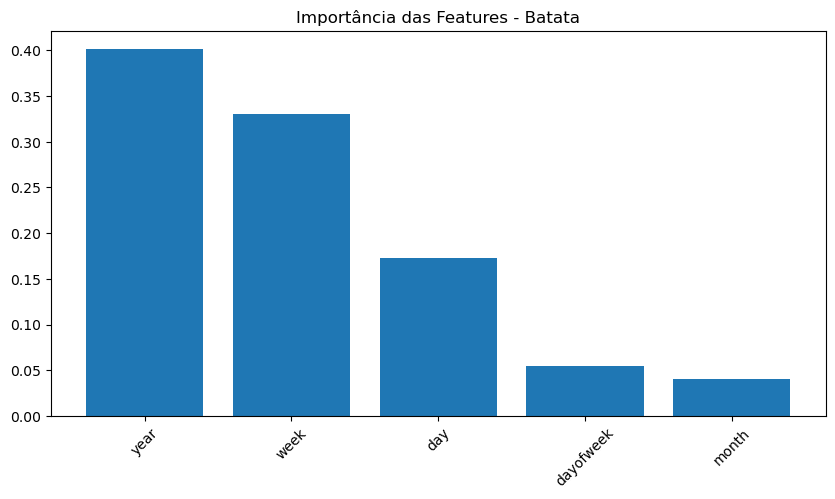


Comparação entre produtos:
         Produto  RMSE Treino  RMSE Teste  R² Treino  R² Teste
0         Tomate         0.21        3.26       0.99     -0.42
1   Banana Prata         0.46        2.48       0.93     -2.13
2  Banana Nanica         0.26        1.58       0.95     -1.90
3         Batata         0.37        1.58       0.97     -0.01


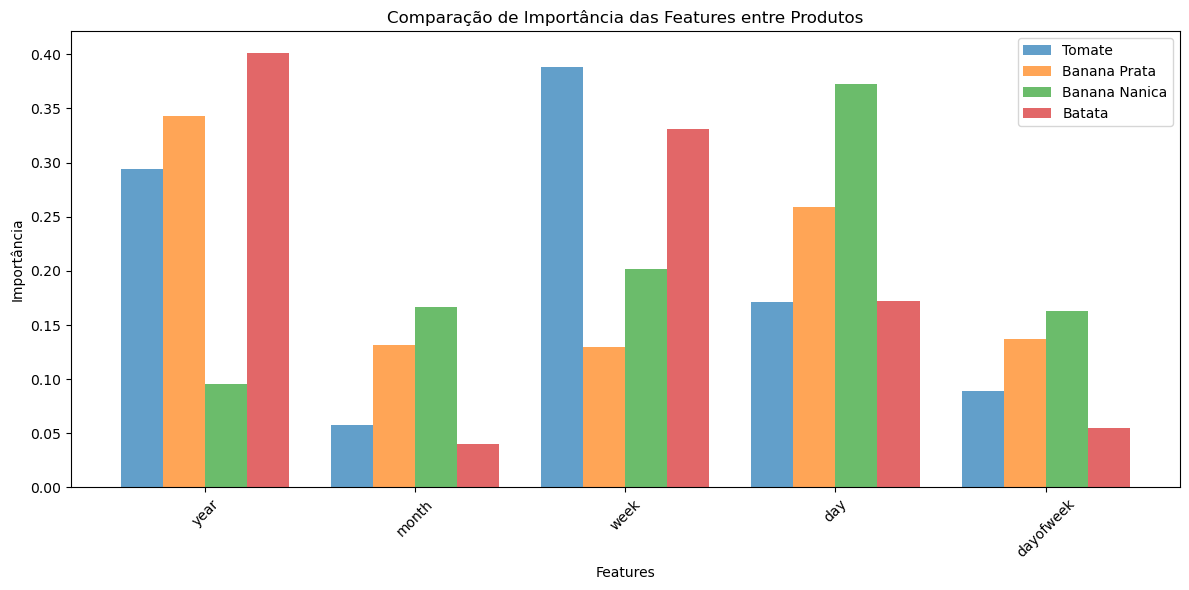

In [77]:
# Function to analyze vegetables with Decision Tree
def analyze_vegetable_prices(vegetable_df, vegetable_name):
    """
    Analyze vegetable prices using Decision Tree Regressor
    
    Parameters:
    -----------
    vegetable_df : DataFrame
        DataFrame containing the vegetable data
    vegetable_name : str
        Name of the vegetable being analyzed
    """
    # Calculate daily averages
    daily_prices = vegetable_df.groupby('Data_Coleta')['PPK'].mean().reset_index()
    daily_prices = daily_prices.set_index('Data_Coleta')
    
    # Create features
    features_df = create_features(daily_prices)
    
    # Split data
    train_size = int(len(features_df) * 0.8)
    train_data = features_df[:train_size]
    test_data = features_df[train_size:]
    
    # Prepare X and y
    features = ['year', 'month', 'week', 'day', 'dayofweek']
    X_train = train_data[features]
    y_train = train_data['PPK']
    X_test = test_data[features]
    y_test = test_data['PPK']
    
    # Train model
    dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
    dt_model.fit(X_train, y_train)
    
    # Make predictions
    train_predictions = dt_model.predict(X_train)
    test_predictions = dt_model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    r2_train = r2_score(y_train, train_predictions)
    r2_test = r2_score(y_test, test_predictions)
    
    # Print metrics
    print(f'\nAnálise para {vegetable_name}:')
    print(f'Training RMSE: {train_rmse:.2f}')
    print(f'Testing RMSE: {test_rmse:.2f}')
    print(f'Training R²: {r2_train:.2f}')
    print(f'Testing R²: {r2_test:.2f}')
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, y_test, label='Valores Reais', color='blue')
    plt.plot(test_data.index, test_predictions, label='Previsões', color='red')
    plt.title(f'Decision Tree: Previsão de Preços - {vegetable_name}')
    plt.xlabel('Data')
    plt.ylabel('Preço por Kg')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': dt_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 5))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Importância das Features - {vegetable_name}')
    plt.xticks(rotation=45)
    plt.show()
    
    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'model': dt_model,
        'feature_importance': feature_importance
    }

# Analyze each vegetable
vegetables = {
    'Tomate': tomate_df,
    'Banana Prata': banana_prata_df,
    'Banana Nanica': banana_nanica_df,
    'Batata': batata_df
}

results = {}
for veg_name, veg_df in vegetables.items():
    results[veg_name] = analyze_vegetable_prices(veg_df, veg_name)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Produto': list(results.keys()),
    'RMSE Treino': [res['train_rmse'] for res in results.values()],
    'RMSE Teste': [res['test_rmse'] for res in results.values()],
    'R² Treino': [res['r2_train'] for res in results.values()],
    'R² Teste': [res['r2_test'] for res in results.values()]
}).round(2)

print("\nComparação entre produtos:")
print(comparison)

# Plot comparative feature importance
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(features))

for i, (veg_name, result) in enumerate(results.items()):
    importance = result['feature_importance'].set_index('feature').reindex(features)['importance']
    plt.bar(index + i * bar_width, importance, bar_width, label=veg_name, alpha=0.7)

plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Comparação de Importância das Features entre Produtos')
plt.xticks(index + bar_width * 1.5, features, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Após análise mais aprofundada, tanto o modelo SARIMA quanto o modelo de Regressão de Árvore de Decisão mostraram-se não adequados para capturar a dinâmica dos preços dos produtos vegetais ao longo do tempo. 

Isso pode se dar ao fato de os modelos não capturarem bem a complexidade e as variações presentes na série temporal, especialmente em relação a fatores sazonais e tendências de longo prazo.